# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium
from tyssue import BulkGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.utils.utils import _to_3d 
from tyssue.core.generation import three_faces_sheet
from tyssue.core.generation import extrude
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.topology.bulk_topology import IH_transition, HI_transition

    
class RNRGeometry(BulkGeometry):
    
    @staticmethod
    def update_centroid(eptm):

        srce_pos = eptm.upcast_srce(eptm.vert_df[eptm.coords])
        trgt_pos = eptm.upcast_trgt(eptm.vert_df[eptm.coords])
        mid_pos = (srce_pos + trgt_pos)/2
        
        eptm.face_df[eptm.coords] = (eptm.sum_face(mid_pos * _to_3d(eptm.edge_df['length'])).values /
                                     eptm.face_df['perimeter'].values[:, np.newaxis])
        srce_pos['cell'] = eptm.edge_df['cell']
        eptm.cell_df[eptm.coords] = srce_pos.groupby('cell').mean()

sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)


eptm.settings['threshold_length'] = 1e-4
print(eptm.Nf, eptm.Ne, eptm.Nv)

render, line = view_3js(eptm)
display(render)

93 414 70


## I→H transition

![IH transition in a bulk and a monolayer](../data/png/IH_transition.png)



In [2]:
e_1011 = 26
eptm.settings['threshold_length'] = 1

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)


render, line = view_3js(eptm)
display(render)

# H → I transition

In [3]:
fa = 93

HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

### Testing for I→H / H →I transition triggers

In [4]:
eptm.settings['threshold_length'] = 1e-3

In [5]:
def find_rearangements(eptm):
    l_th = eptm.settings['threshold_length']
    up_num_sides = eptm.upcast_face(eptm.face_df['num_sides'])   
    shorts = eptm.edge_df[eptm.edge_df['length'] < l_th]
    non_triangular = up_num_sides[up_num_sides > 4 ].index
    edges_IH = set(shorts.index).intersection(non_triangular)

    max_f_length = shorts.groupby('face')['length'].apply(max)
    short_faces = max_f_length[max_f_length < l_th].index
    three_faces = eptm.face_df[eptm.face_df['num_sides'] == 3].index
    faces_HI = set(three_faces).intersection(short_faces)
    return edges_IH, faces_HI

find_rearangements(eptm)

(set(), set())

### Condition 3

This condition is satisfied if `eptm.settings['threshold_length']`
is well defined, i.e, small with respect to the unit length or the
average edge length.

### Condition 4

* (i)  Two edges never share two vertices simultaneously.

_In our half-edge architecture, this is not as straight forward. But I think the condition can
be reformulated as:_ Two edges **from the same face** never share two edges simultanously.
I don't know how to demonstrate this, but I think these are equvalent (to get two edges together, you need to "squeeze" one face between those two.

* (ii) Two polygonal faces never share two or more edges simultaneously.


In [6]:
def condition_4i(eptm):
    
    num_srces = eptm.edge_df.groupby('face')['srce'].apply(lambda s: len(set(s)))
    num_sides = eptm.face_df['num_sides']
    return eptm.face_df[num_srces != num_sides].index


from itertools import combinations

def get_neighbour_face_pairs(eptm):
    pairs = []
    eptm.edge_df['v_pair'] =  eptm.edge_df[['srce', 'trgt']].apply(frozenset, axis=1)

    _ = eptm.edge_df.groupby('v_pair')['face'].apply(
        lambda s: pairs.extend([frozenset((a, b)) for a, b in combinations(s.values, 2)]))
    return pd.Series(pairs).drop_duplicates()

def get_num_common_edges(eptm):
    pairs = get_neighbour_face_pairs(eptm)
    face_v_pair_orbit = eptm.edge_df.groupby('face').apply(
        lambda df: frozenset(df['v_pair']))
    n_common = [
        len(face_v_pair_orbit.loc[fa].intersection(face_v_pair_orbit.loc[fb]))
        if face_v_pair_orbit.loc[fb] != face_v_pair_orbit.loc[fa]
        else -1 for fa, fb in pairs]
    n_common = pd.Series(n_common, index=pd.Index(pairs, name='face_pairs'))
    return n_common

def condition_4ii(eptm):
    n_common = get_num_common_edges(eptm)
    return n_common[n_common > 2]

In [7]:
condition_4i(eptm), condition_4ii(eptm)

(Int64Index([], dtype='int64', name='face'), Series([], dtype: int64))

In [8]:
eptm.settings['threshold_length'] = 0.5

IH_transition(eptm, eptm.edge_df.index[-1])
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

In [11]:
%pdb

Automatic pdb calling has been turned ON


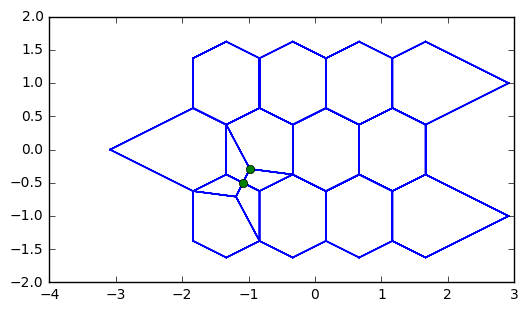

In [12]:
fig, ax = quick_edge_draw(eptm)
e_1011 = eptm.edge_df.index[-1]
vs_1011 = eptm.vert_df.loc[eptm.edge_df.loc[e_1011, ['srce', 'trgt']].values, eptm.coords]

ax.plot(vs_1011.x, vs_1011.y, 'o')

In [13]:
IH_transition(eptm, eptm.edge_df.index[-1])
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

ValueError: no face with vertices 51, 51, 71 and 72 was found for cell 0

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/tyssue-0.0.2-py3.5.egg/tyssue/topology/bulk_topology.py(411)_add_edge_to_existing()
    409         raise ValueError('no face with vertices {}, {}, {} and {}'
    410                          ' was found for cell {}'
--> 411                          .format(vi, vj, new_srce, new_trgt, cell))
    412     eptm.edge_df = eptm.edge_df.append(cell_edges.iloc[-1],
    413                                        ignore_index=True)

ipdb> cell_edges
           dy    length  srce        dx            nz  trgt  face        nx  \
3   -0.750000  0.750000     4  0.000000  3.192054e-01     3     0  0.021698   
7    0.083831  0.664532    68 -0.645585  2.787831e-01     4     0  0.062555   
10  -0.250000  0.559017     3  0.500000  2.378534e-01     6     0  0.007233   
18   0.666169  0.766282    16 -0.354415  2.894657e-01    68     0  0.015799   
24   0.250000  0.559017     6  0.500000  2.750497e-01    16     0 -0.007233   
70   0.75000

In [114]:
render, line = view_3js(eptm)
display(render)